# **1. Download das Bibliotecas**

In [29]:
#%pip install river pandas==2.2.2 scipy==1.13.1 numpy==1.26.1

In [30]:
#%pip install matplotlib yfinance scikit-learn scikit-optimize

# **2. Importações**

## Geral

In [31]:
# Importação de libs auxiliares
import numpy as np
import pandas as pd

# Importando as classes refatoradas
from preprocessamento.SeriesProcessor import SeriesProcessor
from otimizador.Optimizer import OtimizadorModelosSklearn
from avaliacao.AvaliadorDriftBase import AvaliadorBatch
from avaliacao.AvaliadorDriftBase import AvaliadorPassivo
from avaliacao.AvaliadorDriftBase import AvaliadorPassivoDrift
from utils.Visualizer import Visualizer

# limpar o log
import warnings
#warnings.filterwarnings("ignore")

## Importação dos Detectores e Regressores Off-line e On-line

In [32]:
# importando o framework
from frameLiedson.FrameLiedson import FrameLiedson
from frameGabriel.SmartWindow import SmartWindow

In [33]:
# Importando detectores de drift
from detectores.ADWINDetector import ADWINDetector
from detectores.DDMDetector import DDMDetector
from detectores.EDDMDetector import EDDMDetector
from detectores.FHDDMDetector import FHDDMDetector
from detectores.HDDM_ADetector import HDDM_ADetector
from detectores.PageHinkleyDetector import PageHinkleyDetector
from detectores.HDDM_WDetector import HDDM_WDetector
from detectores.KSWINDetector import KSWINDetector

In [34]:
# Importando modelos offline
from regressores.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from regressores.modelosOffline.KneighborsRegressorModelo import KneighborsRegressorModelo
from regressores.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from regressores.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from regressores.modelosOffline.SVRModelo import SVRModelo
from regressores.modelosOffline.RandomForestModelo import RandomForestModelo
from regressores.modelosOffline.MLPRegressorModelo import MLPRegressorModelo

In [35]:
# Importando modelos online
from regressores.modelosOnline.BayesianLinearRegressionModelo import BayesianLinearRegressionModelo
from regressores.modelosOnline.HoeffdingTreeRegressorModelo import HoeffdingTreeRegressorModelo
from regressores.modelosOnline.KNNRegressorOnlineModelo import KNNRegressorOnlineModelo
from regressores.modelosOnline.LinearRegressionOnlineModelo import LinearRegressionOnlineModelo
from regressores.modelosOnline.MLPRegressorOnlineModelo import MLPRegressorOnlineModelo
from regressores.modelosOnline.OSELM import OSELMModelo

# **3. Dados e Pré-processamento**

## Séries Temporais

In [36]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "IXIC",
    "DJI",
    "GSPC",
    "BVSP",
    "USDBRLX"
]

In [37]:
#SeriesProcessor.baixar_e_salvar_series(series)

## Parâmetros de processamento

In [38]:
# Definindo parâmetros para processamento
tamanho_batch = 300
lags = 10
serie_escolhida = series[5]
print(f"Processando série: {serie_escolhida}")

Processando série: BVSP


## Processamento dos dados

In [39]:
# Baixando os dados da ação
serie_temporal = SeriesProcessor.carregar_serie_csv(serie_escolhida)

# Normalizando a série temporal
serie_temporal = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal.shape}")

# Gerando janelas temporais
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal, lags)
print(f"Shape dos dados de entrada: {X.shape}")
print(f"Shape dos dados de saída: {Y.shape}")

Shape da série após normalização: (7927, 1)
Shape dos dados de entrada: (7917, 10)
Shape dos dados de saída: (7917, 1)


# **4. Otimização de Hiperparâmetros**

In [40]:
arquivo_parametros = "melhores_parametros.json"
otimizador = OtimizadorModelosSklearn(n_iter=20)

In [41]:
melhores_parametros = otimizador.otimizar(
    X[tamanho_batch:], 
    Y[tamanho_batch:], 
    salvar_em = arquivo_parametros)

# **5. Definição dos Modelos**

## Regressores off-line

In [42]:
modelos_offline = [
    LinearRegressionModelo,
    KneighborsRegressorModelo,
    LassoRegressionModelo,
    MLPRegressorModelo,  
    RandomForestModelo,
    RidgeRegressionModelo,
    SVRModelo
]

## Regressores on-line

In [43]:
modelos_online = [
        BayesianLinearRegressionModelo,
        HoeffdingTreeRegressorModelo,
        KNNRegressorOnlineModelo,
        LinearRegressionOnlineModelo
    ]

# **6. Prequential com Detecção de Drift**

In [44]:
avaliador = AvaliadorBatch()
predicoes_ativo, deteccoes_ativo, mae_ativo = avaliador.executar_avaliacao(X, Y, tamanho_batch, LinearRegressionModelo, KSWINDetector)


Drift detectado para LR + KSWIN nos índices: [482, 961, 1643, 2088, 3816, 4216, 5290, 6117, 6629, 7285, 7840]


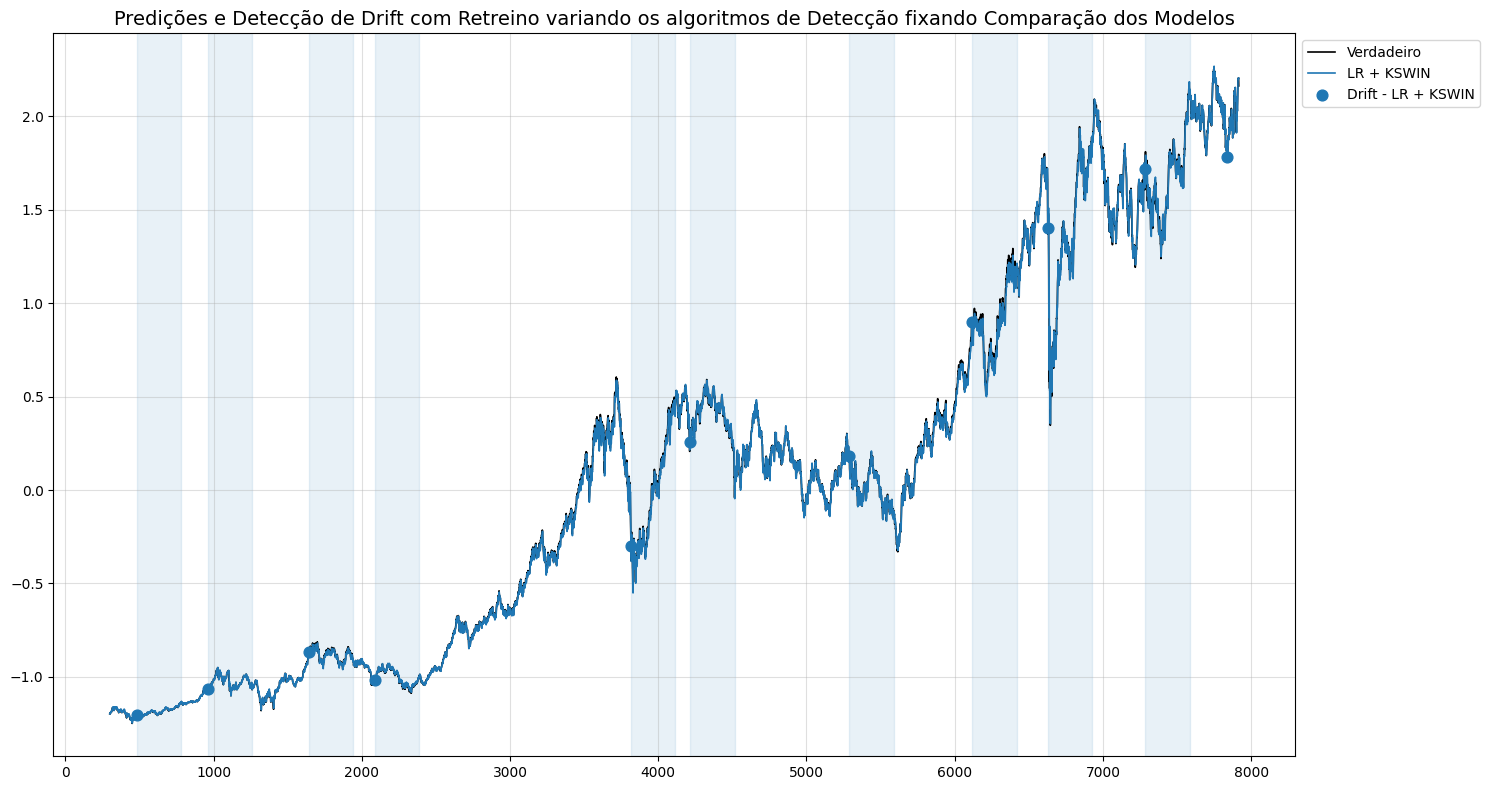

In [45]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_ativo],
                  ["LR + KSWIN"],
                  {"LR + KSWIN": deteccoes_ativo},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )


# **7. Prequential Passivo**

In [46]:
avaliador = AvaliadorPassivo()
predicoes_passivo, mae_passivo = avaliador.executar_avaliacao(X, Y, tamanho_batch, OSELMModelo)


Nenhum drift detectado para OSELMModelo.


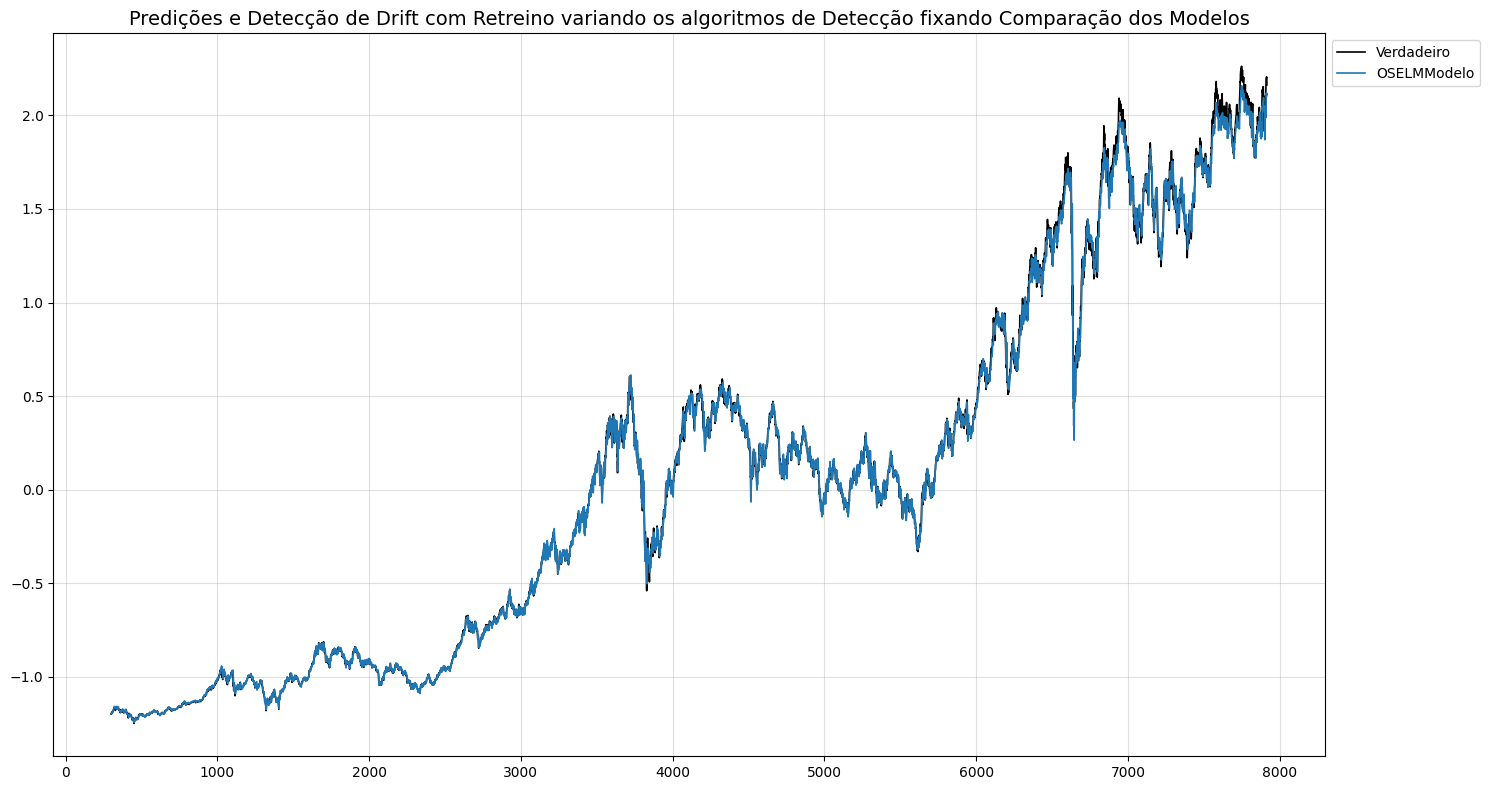

In [47]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_passivo],
                  ["OSELMModelo"],
                  {"OSELMModelo": None},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )

# **8. Prequential Passivo com Drift**

In [48]:
avaliador = AvaliadorPassivoDrift()
predicoes_ativo_online, deteccoes_ativo_online, mae_ativo_online = avaliador.executar_avaliacao(X, Y, tamanho_batch, BayesianLinearRegressionModelo, KSWINDetector)


Drift detectado para BayesianLinearRegressionModelo + KSWIN nos índices: [461, 909, 1310, 1782, 2374, 2887, 3299, 3821, 4533, 5120, 5576, 6630, 7808]


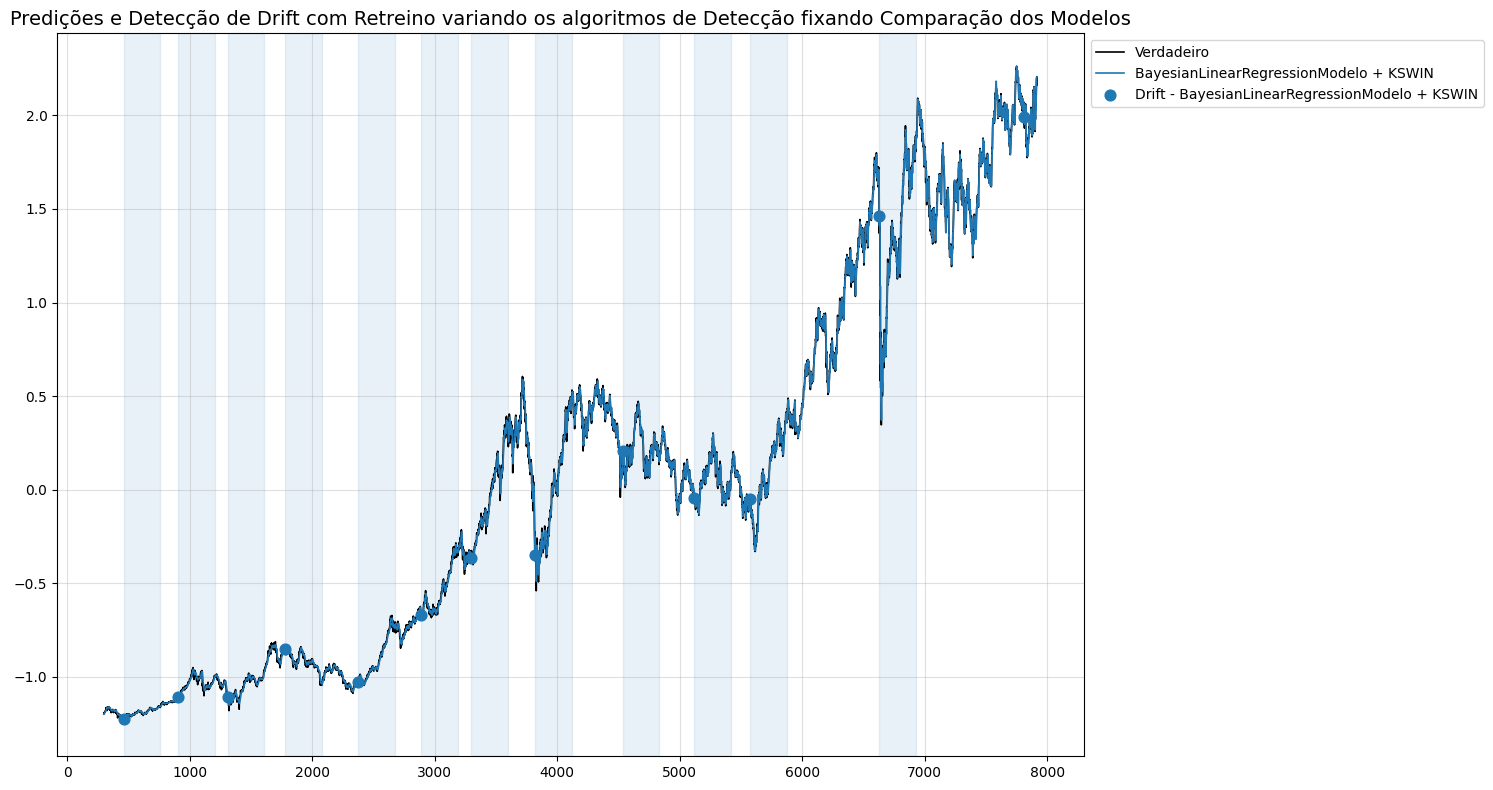

In [49]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_ativo_online],
                  ["BayesianLinearRegressionModelo + KSWIN"],
                  {"BayesianLinearRegressionModelo + KSWIN": deteccoes_ativo_online},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )


# **9. Framework Liedson**

In [50]:
#framework = FrameLiedson(BayesianLinearRegressionModelo, KSWINDetector, 10, tamanho_batch)
#predicoes_frame, deteccoes_frame, mae_frame = framework.prequential(X, Y, tamanho_batch)
predicoes_frame, deteccoes_frame, mae_frame = None, None, None

In [51]:
'''
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_frame],
                  ["Liedson"],
                  {"Liedson": deteccoes_frame},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )
'''

'\n# Plotando os resultados\nVisualizer.plotar_resultados_multi(Y,\n                  [predicoes_frame],\n                  ["Liedson"],\n                  {"Liedson": deteccoes_frame},\n                  tamanho_batch,\n                  detector_or_modelo="Comparação dos Modelos",\n                  )\n'

# **10. Framework Gabriel**

In [52]:
framework = SmartWindow(LinearRegressionModelo, KSWINDetector, 0.003)
predicoes_frame2, deteccoes_frame2, mae_frame2 = framework.prequential(X, Y, tamanho_batch)


Drift detectado para Gabriel nos índices: [484, 967, 1637, 2087, 2577, 3817, 4222, 4638, 5311, 5979, 6641]


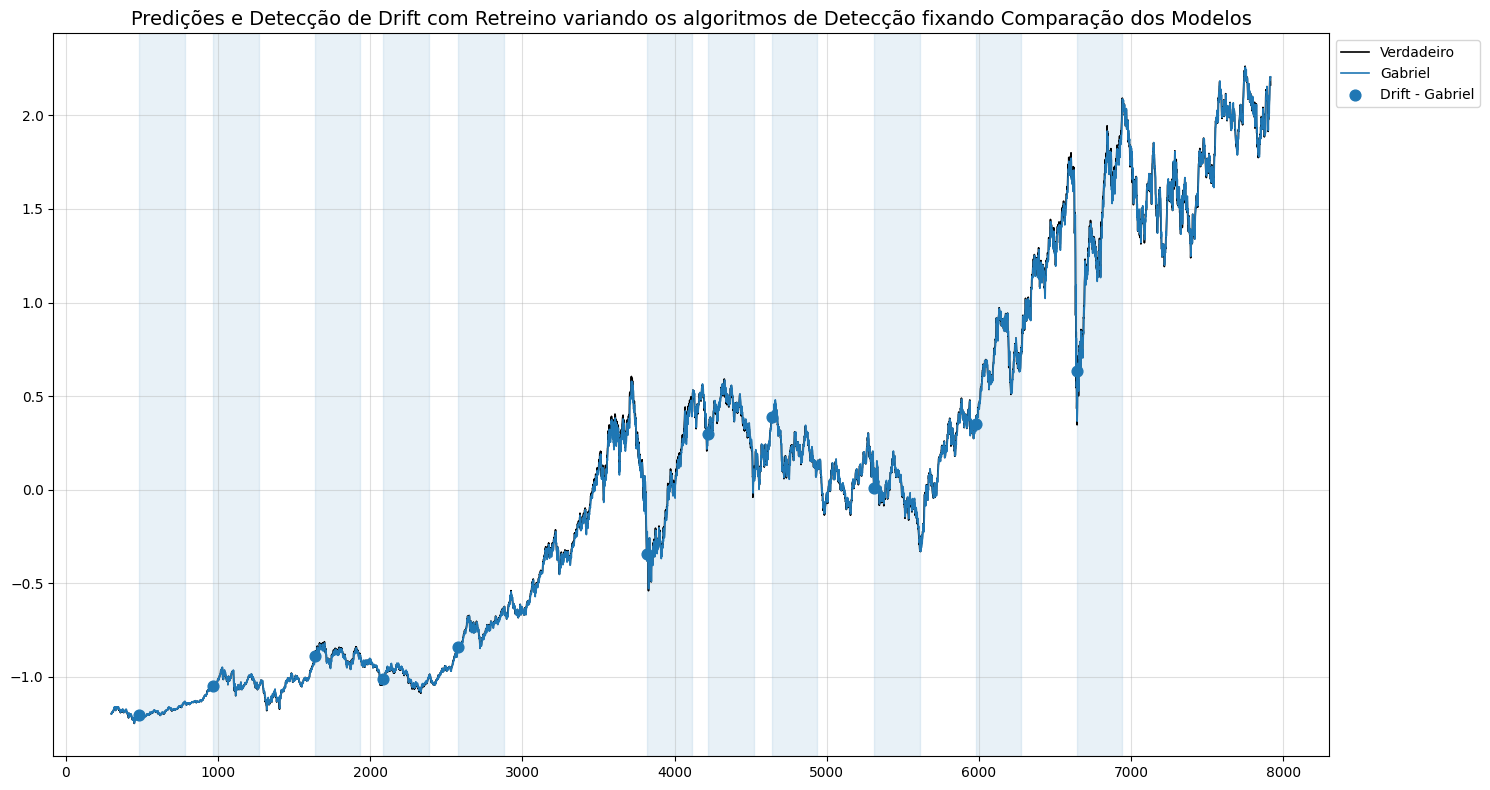

In [53]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_frame2],
                  ["Gabriel"],
                  {"Gabriel": deteccoes_frame2},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )

# **11. Comparação**

In [ ]:
print("LR_KSWIN: ", mae_ativo)
print("OS-ELM: ", mae_passivo)
print("BayesianOnline: ", mae_ativo_online)
print("Liedson: ", mae_frame)
print("Gabriel: ", mae_frame2)

LR  [0.01681683]
[0.02118385]
[0.01753887]
None
[0.01648856]



Drift detectado para Gabriel nos índices: [484, 967, 1637, 2087, 2577, 3817, 4222, 4638, 5311, 5979, 6641]


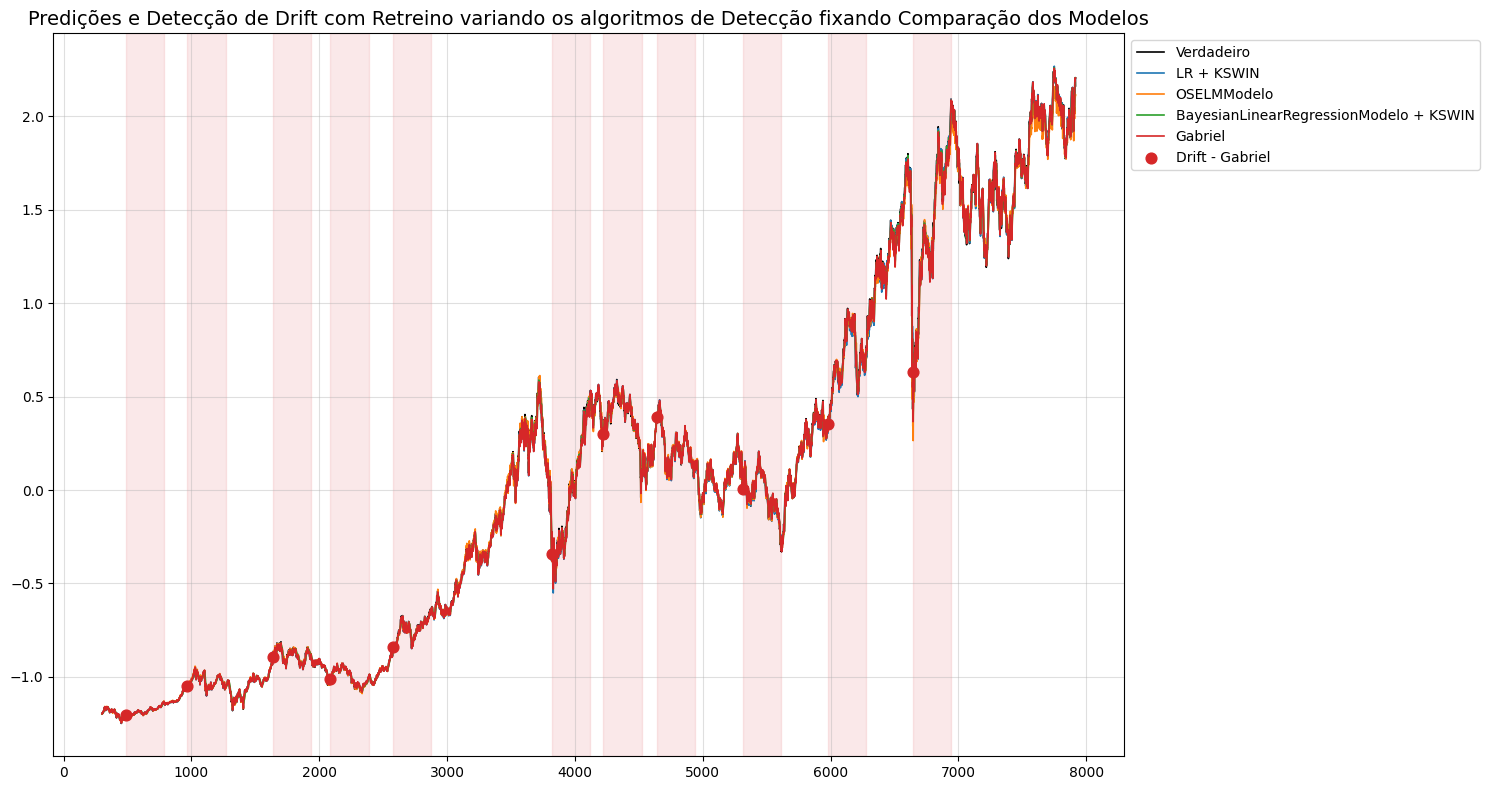

In [55]:
# Plotando os resultados
Visualizer.plotar_resultados_multi(Y,
                  [predicoes_ativo,
                   predicoes_passivo,
                   predicoes_ativo_online,
                   #predicoes_frame,
                   predicoes_frame2],
                  ["LR + KSWIN",
                   "OSELMModelo",
                   "BayesianLinearRegressionModelo + KSWIN",
                   #"Liedson",
                   "Gabriel"],
                  {"Gabriel": deteccoes_frame2},
                  tamanho_batch,
                  detector_or_modelo="Comparação dos Modelos",
                  )